![Dynamat Banner](docs/figures/banner.png)

# Split-Hopkinson Pressure Bar (SHPB) Numerical Analysis

Authors: [Erwin Cazares<sup>1</sup>](ecazares3@miners.utep.edu), </br>

Contributors: [Dr Brian E. Schuster<sup>1</sup>](bschuster@utep.edu), [David K Santacruz<sup>1</sup>](dksantacruz@miners.utep.edu) </br>

<sup>1</sup> Dynamic Materials Laboratory at the University of Texas at El Paso, TX USA 79968</br>

Date of creation: Fall 2024 </br>
Date of last revision: Spr 2025 </br>

In [236]:
import numpy as np
import pandas as pd
from scripts.rdf_wrapper import RDFWrapper
from scripts.SHPB_RDFSignalFetch import RawExperimentDataHandler
import plotly.graph_objects as go
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from numpy.linalg import norm
import pywt
import os, io
import glob

# Get the directory of the current script or the parent directory
script_dir = os.getcwd()
print(f'Current working directory = {script_dir}')

result_folder = os.path.join(script_dir, "results", "test") ### Change this!
experiment_name = "test_001" ### Change this!

fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)

Current working directory = E:\DynaMat_UTEP\SHPB_Toolkit


In [237]:
# Demo data under data_demo/**/*.txt files
data_files = glob.glob(os.path.join(script_dir, "data", "*.ttl"), recursive=True) 
print(f"Number of demo files : {len(data_files)} \n")
print(f"Last 10 files names:")
for idx, f_name in enumerate(data_files[-10:]):
    print(idx, f_name, "\n")

Number of demo files : 172 

Last 10 files names:
0 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250426_A356_LAB_RT_010.ttl 

1 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250426_A356_LAB_RT_011.ttl 

2 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250428_SS316_LAB_RT_016.ttl 

3 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250428_SS316_LAB_RT_017.ttl 

4 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250429_SS316_LAB_RT_018.ttl 

5 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250429_SS316_LAB_RT_019.ttl 

6 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250429_SS316_LAB_RT_020.ttl 

7 E:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430_SS316_LAB_RT_021.ttl 

8 E:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430_SS316_LAB_RT_022.ttl 

9 E:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430_SS316_LAB_RT_023.ttl 



In [239]:
# Select the desired data file
idx = -9 ### Change this!
print(f"Selected {data_files[idx]} for analysis \n")

experiment = RDFWrapper(data_files[idx])
handler = RawExperimentDataHandler(experiment)

# Fetch gauge signals
incident_gauge_signals = handler.fetch_gauge_signals("dynamat:IncidentSensorSignal")
transmitted_gauge_signals = handler.fetch_gauge_signals("dynamat:TransmittedSensorSignal")
time_sensor_signals = handler.fetch_sensor_signals("dynamat:TimeSensorSignal")

raw_data = pd.DataFrame({
  "Time": time_sensor_signals.iloc[:, 0], 
    "Incident Raw": incident_gauge_signals.iloc[:,0],
    "Transmitted Raw": transmitted_gauge_signals.iloc[:,0]
})

raw_data.info()

Selected E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250426_A356_LAB_RT_011.ttl for analysis 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             160000 non-null  float32
 1   Incident Raw     160000 non-null  float32
 2   Transmitted Raw  160000 non-null  float32
dtypes: float32(3)
memory usage: 1.8 MB


In [240]:
# This variables must be changed for the specific test, see documentation for the metadata.

# Extract Test Metadata
testing_conditions_uri = experiment.get_instances_of_class("dynamat:TestingConditions")[0]
test_type = experiment.get_objects(testing_conditions_uri, "dynamat:hasTestType")[0].split("#")[-1]
test_mode = experiment.get_objects(testing_conditions_uri, "dynamat:hasTestMode")[0].split("#")[-1]
test_temperature = experiment.get_objects(testing_conditions_uri, "dynamat:hasTestTemperature")[0].split("#")[-1]
trap_condition = experiment.get_objects(testing_conditions_uri, "dynamat:hasMomentumTrap")[0].split("#")[-1]

print("Tetst Metadata")
print("-----"*10)
print(f"Test Type: {test_type}")
print(f"Test Mode: {test_mode}")
print(f"Test Temperature: {test_temperature}")
print(f"Momentum Trap Condition: {trap_condition}")

# Striker Conditions
striker_bar_uri = experiment.get_instances_of_class("dynamat:StrikerBar")[0]
striker_bar_material = experiment.get_objects(striker_bar_uri, "dynamat:hasMaterial")[0]
striker_bar_dimensions = experiment.get_objects(striker_bar_uri, "dynamat:hasDimension")
striker_bar_properties = experiment.get_objects(striker_bar_uri, "dynamat:hasMechanicalProperty")

for prop in striker_bar_dimensions:
    if "OriginalLength" in prop:
        striker_length = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm
    elif "Velocity" in prop:
        striker_velocity = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # m/s
    elif "OriginalCrossSectionalArea" in prop:
        bar_cross_section = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm^2
        bar_radius = np.sqrt(bar_cross_section / np.pi)
        
for prop in striker_bar_properties:
    if "Density" in prop:
        bar_density = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # kg/mm3
    elif "Poissons" in prop:
        bar_poissons = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # unitless
    elif "ElasticModulus" in prop:
        bar_elastic_modulus = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # MPa
    elif "WaveSpeed" in prop:
        bar_wave_speed = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # MPa
        
print("\n Striker Conditions")
print("-----"*10)
print(f"Striker Material: {striker_bar_material.split('#')[-1]}")
print(f"Stiker Length: {striker_length:.3f} mm")
print(f"Stiker Velocity: {striker_velocity:.3f} m/s or mm/ms")

print("\n Bar Material Properties")
print("-----"*10)
print(f"Bar Density: {bar_density:.3e} kg/mm^3")
print(f"Bar Posisson's Ratio: {bar_poissons}")
print(f"Bar Elastic Modulus: {bar_elastic_modulus:.3e} MPa")
print(f"Bar Wave Speed: {bar_wave_speed:.3f} m/s or mm/ms")
print(f"Bar Cross Section: {bar_cross_section:.3f} mm^2")
print(f"Bar Radius: {bar_radius:.3f} mm")

# Strain Gauge Distances
incident_bar_uri = experiment.get_instances_of_class("dynamat:IncidentBar")[0]
incident_strain_gauge = experiment.get_objects(incident_bar_uri, "dynamat:hasStrainGauge")[0]
incident_strain_gauge_dist = experiment.get_objects(incident_strain_gauge, "dynamat:hasDimension")[0]
incident_strain_gauge_dist = float(experiment.get_objects(incident_strain_gauge_dist, "dynamat:hasValue")[0])

transmitted_bar_uri = experiment.get_instances_of_class("dynamat:TransmittedBar")[0]
transmitted_strain_gauge = experiment.get_objects(transmitted_bar_uri, "dynamat:hasStrainGauge")[0]
transmitted_strain_gauge_dist = experiment.get_objects(transmitted_strain_gauge, "dynamat:hasDimension")[0]
transmitted_strain_gauge_dist = float(experiment.get_objects(transmitted_strain_gauge_dist, "dynamat:hasValue")[0])

print("\n Strain Gauge Distances")
print("-----"*10)
print(f"Incident Strain Gauge Distance: {incident_strain_gauge_dist:.3f} mm")
print(f"Transmitted Strain Gauge Distance: {transmitted_strain_gauge_dist:.3f} mm")

if test_type == "SpecimenTest": 
    specimen_data_uri = experiment.get_instances_of_class("dynamat:SHPBSpecimen")[0]
    specimen_material = experiment.get_objects(specimen_data_uri, "dynamat:hasMaterial")[0]
    specimen_dimensions = experiment.get_objects(specimen_data_uri, "dynamat:hasDimension")
    for prop in specimen_dimensions:
        if "OriginalLength" in prop:
            specimen_length = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm
        elif "DeformedLength" in prop:
            specimen_length_deformed = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm
        elif "OriginalCrossSectionalArea" in prop:
            specimen_cross = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm^2
        elif "DeformedCrossSectionalArea" in prop:
            specimen_cross_deformed = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm^2  
            
    print("\n Specimen Dimensions")
    print("-----"*10)
    print(f"Specimen Material: {specimen_material.split('#')[-1]}")
    print(f"Specimen Original Length: {specimen_length:.3f} mm")
    specimen_length = 6.36
    print(f"Specimen Deformed Length: {specimen_length_deformed:.3f} mm")
    print(f"Specimen Cross Section: {specimen_cross:.3f} mm^2")
    specimen_cross = 31.76904
    print(f"Specimen Deformed Cross Section: {specimen_cross_deformed:.3f} mm^2")

Tetst Metadata
--------------------------------------------------
Test Type: SpecimenTest
Test Mode: LABMode
Test Temperature: RoomTemperature
Momentum Trap Condition: MomentumTrapEngaged

 Striker Conditions
--------------------------------------------------
Striker Material: SteelC350
Stiker Length: 457.200 mm
Stiker Velocity: 22.960 m/s or mm/ms

 Bar Material Properties
--------------------------------------------------
Bar Density: 8.082e-06 kg/mm^3
Bar Posisson's Ratio: 0.29
Bar Elastic Modulus: 2.000e+05 MPa
Bar Wave Speed: 4953.321 m/s or mm/ms
Bar Cross Section: 71.251 mm^2
Bar Radius: 4.762 mm

 Strain Gauge Distances
--------------------------------------------------
Incident Strain Gauge Distance: 1219.200 mm
Transmitted Strain Gauge Distance: 1219.200 mm

 Specimen Dimensions
--------------------------------------------------
Specimen Material: A356
Specimen Original Length: 6.480 mm
Specimen Deformed Length: 2.660 mm
Specimen Cross Section: 30.876 mm^2
Specimen Deformed C

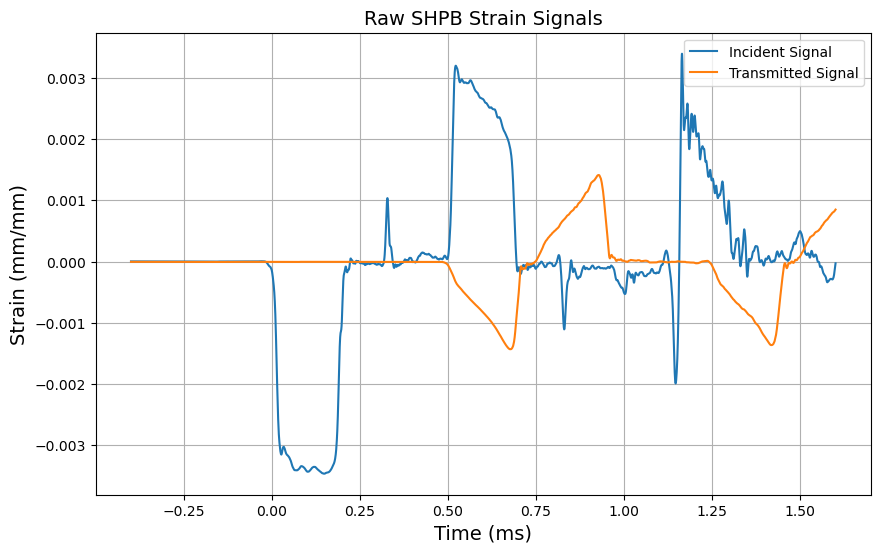

In [241]:
plt.figure(figsize=(10,6))
plt.plot(raw_data["Time"], raw_data["Incident Raw"], label = "Incident Signal")
plt.plot(raw_data["Time"], raw_data["Transmitted Raw"], label = "Transmitted Signal")
plt.xlabel("Time (ms)", fontsize = 14)
plt.ylabel("Strain (mm/mm)", fontsize =14)
plt.title("Raw SHPB Strain Signals", fontsize=14)
plt.legend(fontsize=10)
plt.grid()

# Save raw data to csv
raw_data.to_csv(os.path.join(fig_path, f"{experiment_name}_primary_data.csv"))

In [242]:
strain_raw_fig = go.Figure()
        
strain_raw_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Incident Raw"], mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2)))
strain_raw_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Transmitted Raw"], mode='lines', name='Transmitted',
                                                        line=dict(color='red', width=2)))           
# Customize layout
strain_raw_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Converted Strain Signal vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0, font=dict(size=12, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

        
# Display the interactive plot
strain_raw_fig.write_html(os.path.join(fig_path, f"{experiment_name}_signal_raw.html"), include_plotlyjs='cdn')

## Specimen Analysis. 

### Script Functions 

In [243]:
def find_pulse_edges(edges, signal, pulse_window):
    """
    Identifies and classifies pulses using value-based sign tracking and validates pulse windows.
    Designed to separate overlapping pulses such as incident and reflected waves in SHPB data.
    
    Parameters:
    edges (array-like): List of detected edge indices.
    signal (array-like): The reference signal (e.g., SHPB strain gauge data).
    pulse_window (float): Expected pulse duration (in index units).
    
    Returns:
    tuple: (List of valid pulse start indices, Dictionary of all pulse properties)
    """
    rising_edges_start_idx = []
    falling_edges_start_idx = [] 
    window_start_approx = []
    window_end_approx = []
    
    edge_results = {
        "start": [],
        "end": [],
        "n_points": [],
        "direction": []
    }

    if len(edges) == 0:
        return window_start_approx, edge_results

    # Compute first derivative of the signal
    derivative = np.gradient(signal)
    
    edges = np.sort(edges)
    grouped_edges = []
    current_group = [edges[0]]
    current_sign = current_sign = np.sign(signal[edges[0]]) if signal[edges[0]] != 0 else 1

    for i in range(1, len(edges)):
        edge = edges[i]
        signal_sign = np.sign(signal[edge])

        # Start new group if sign of signal changes or if edge is too far from previous
        if signal_sign != current_sign or edge - edges[i - 1] > 2000:
            grouped_edges.append(current_group)
            current_group = [edge]
            current_sign = signal_sign
        else:
            current_group.append(edge)

    grouped_edges.append(current_group)

    # Analyze each group to determine direction and properties
    for group in grouped_edges:
        start_idx = group[0]
        end_idx = group[-1]
        n_points = len(group)
        avg_slope = np.mean(derivative[start_idx:end_idx])

        if avg_slope > 0: 
            direction = 1
            rising_edges_start_idx.append(start_idx)
        else: 
            direction = -1
            falling_edges_start_idx.append(start_idx)

        edge_results["start"].append(start_idx)
        edge_results["end"].append(end_idx)
        edge_results["n_points"].append(n_points)
        edge_results["direction"].append(direction)

    # Match rising and falling edges using window constraint
    for rise_idx in rising_edges_start_idx:
        valid_falls = [
            fall_idx for fall_idx in falling_edges_start_idx
            if pulse_window * 0.8 <= abs(rise_idx - fall_idx) <= pulse_window * 2.5
        ]

        if valid_falls:
            best_fall_idx = min(valid_falls, key=lambda x: abs(rise_idx - x))
            window_start_approx.append(min(rise_idx, best_fall_idx))
            window_end_approx.append(max(rise_idx, best_fall_idx))

    return window_start_approx, window_end_approx

In [244]:
def extract_pulse_window(signal, signal_start_approx, signal_end_approx, pulse_points, pp_extra, tail, negative = True):
    
    search_range = np.arange(int(signal_start_approx-(pulse_points*pp_extra)),
                             int(signal_start_approx+(pulse_points*(1+pp_extra)))
                             ,1)
    
    signal_subset = np.array(signal[search_range])    
    signal_gradient = np.gradient(signal_subset)

    if negative:
        signal_start_slope = np.argmin(signal_gradient)
        
    else: 
        signal_start_slope = np.argmax(signal_gradient)
        
    signal_start_zero = np.where(np.isclose(signal_subset[:signal_start_slope], 0, atol=5e-5))[0][-1]
    try:
        signal_end_zero = np.where(np.isclose(signal_subset[signal_start_slope:], 0, atol=11e-5))[0][0]
    except:
        signal_end_zero = len(signal_subset)
        print("Using last subset idx as signal end")
    
    window_range = np.arange(int(signal_start_zero - tail), int(signal_start_slope + signal_end_zero + tail), 1)    
    try:
        extracted_signal = signal_subset[window_range]
    except:
        print("Tail window to large, starting at zero")
        extracted_signal = signal_subset[signal_start_zero:]  
        
        
    time_start_idx = int(signal_start_approx-(pulse_points*pp_extra) + signal_start_zero)
    
    return extracted_signal, time_start_idx


In [245]:
## Criteria for Genetic Algorithm
def det_pulse_correlation(incident, transmitted, reflected, idx):
    """
    Pearson r between incident[idx] and (T-R)[idx].
    """
    cand = transmitted - reflected
    inc  = incident
    inc  = inc[idx]
    cand = cand[idx]

    if inc.std() == 0 or cand.std() == 0:          # guard /0
        return -1.0
    return np.corrcoef(inc, cand)[0, 1]            # [-1, 1]

def det_pulse_correlation2(incident, transmitted, reflected, idx):
    """
    Pearson r between incident[idx] and (T-R)[idx].
    """
    cand = incident + reflected
    trans  = incident
    trans  = trans[idx]
    cand = cand[idx]

    if trans.std() == 0 or cand.std() == 0:          # guard /0
        return -1.0
    return np.corrcoef(trans, cand)[0, 1]            # [-1, 1]
    

def det_bar_displacement(wave_speed, incident, transmitted, reflected):
    """
    Determines the bar displacement over the strain pulse signals
    """
    u2 = bar_wave_speed * (incident + reflected) # Two wave analysis
    u1 = bar_wave_speed * (transmitted) # One Wave Analysis

    return u1, u2

def det_eng_strain_rate(wave_speed, specimen_l, incident, transmitted, reflected):
    """
    Calculates the specimen eng strain rate from strain signals. 
    """
    sr_3w = (wave_speed / specimen_l) * (incident - reflected - transmitted)
    sr_1w = (2*wave_speed*reflected) / specimen_l

    return sr_3w, sr_1w

def det_eng_strain(wave_speed, specimen_l, incident, transmitted, reflected, time):
    """
    Calculates the specimen strain from strain signals. 
    """
    strain_3w = (wave_speed / specimen_l) * cumulative_trapezoid(
                    (incident- reflected - transmitted),
                    time, initial=0)
    
    strain_1w = ((2*wave_speed) / specimen_l) * cumulative_trapezoid(
                    reflected, time, initial=0)

    return strain_3w, strain_1w

# ------------------------------------------------------------------
# 2.  LOW‑LEVEL UTILITIES
# ------------------------------------------------------------------
def shift_signal(sig, shift):
    """Zero‑pad shift (positive = right, negative = left), length preserved."""
    if shift == 0:
        return sig
    n = len(sig)
    if shift > 0:
        return np.pad(sig, (shift, 0), mode="constant")[:n]
    else:                                     # shift < 0
        return np.pad(sig, (0, -shift), mode="constant")[-shift:]

def compute_fitness_physical(shift_t, shift_r,
                             incident, transmitted, reflected,
                             idx, time,         # linear window + full time
                             bar_c, specimen_L, # material constants
                             w):
    """
    Composite GA fitness built from:
      w['corr']  : pulse Pearson r  (larger better)
      w['u']     : displacement RMSE  (smaller better)
      w['sr']    : strain-rate RMSE  (smaller better)
      w['e']     : strain RMSE       (smaller better)
    'w' is a dict of non-negative weights.
    """
    # --- apply test shifts ---
    T = shift_signal(transmitted, shift_t)
    R = shift_signal(reflected,   shift_r)

    # -------- 1. shape correlation --------
    r = det_pulse_correlation(incident, T, R, idx)   # [-1, +1]
    r2 = det_pulse_correlation2(incident, T, R, idx)

    # -------- 2. bar displacement ---------
    u1, u2 = det_bar_displacement(bar_c, incident, T, R)
    u_rmse = np.sqrt(np.mean((u1[idx] - u2[idx])**2))

    # -------- 3. strain rate --------------
    sr1, sr3 = det_eng_strain_rate(bar_c, specimen_L,
                                   incident, T, R)
    sr_rmse = np.sqrt(np.mean((sr1[idx] - sr3[idx])**2))

    # -------- 4. strain -------------------
    e1, e3 = det_eng_strain(bar_c, specimen_L,
                            incident, T, R, time)
    e_rmse = np.sqrt(np.mean((e1[idx] - e3[idx])**2))

    # -------- combine into a bigger-is-better fitness --------
    # Convert the three RMSEs (where 0 is best) into similarity scores
    # by using 1 / (1 + RMSE).  Then weight and sum.
    sim_u  = 1.0 / (1.0 + u_rmse)
    sim_sr = 1.0 / (1.0 + sr_rmse)
    sim_e  = 1.0 / (1.0 + e_rmse)

    fitness = (
        w['corr'] * r +
        w['corr2'] * r2 +
        w['u']    * sim_u +
        w['sr']   * sim_sr +
        w['e']    * sim_e
    )
    return fitness

def tournament_select(pop, fits, k=9):
    """Return one individual chosen by k‑way tournament."""
    sel = np.random.choice(len(pop), k, replace=False)
    best = sel[np.argmax([fits[i] for i in sel])]
    return pop[best]


### Calculate Pulse Properties

In [246]:
# Determine Pulse Duration
delta_t = np.mean(np.diff(raw_data["Time"]))
print("\n Pulse Properties")
print("-----"*10)
print(f"Average Delta T: {delta_t:.3e} ms")

pulse_duration = (2*striker_length) / bar_wave_speed
print(f"Pulse Duration from Calibrated Bar Wave Speed: {pulse_duration:.3f} ms")

pulse_data_points = int(pulse_duration / delta_t) 
print(f"Pulse Data Points from Calibrated Bar Wave Speed: {pulse_data_points} points")

pulse_length = 2*striker_length
pulse_stress = (1/2) * bar_density * bar_wave_speed * striker_velocity * 1000
pulse_strain = (1/2) * (striker_velocity / bar_wave_speed)

print(f"Pulse Length: {pulse_length:.3f} mm")
print(f"Pulse Stress: {pulse_stress:.3f} MPa")
print(f"Pulse Strain: {pulse_strain:.3e} mm/mm")


 Pulse Properties
--------------------------------------------------
Average Delta T: 1.250e-05 ms
Pulse Duration from Calibrated Bar Wave Speed: 0.185 ms
Pulse Data Points from Calibrated Bar Wave Speed: 14768 points
Pulse Length: 914.400 mm
Pulse Stress: 459.604 MPa
Pulse Strain: 2.318e-03 mm/mm


### Extract Pulse Windows

In [247]:
# Define wavelet (Derivatives of Gaussians are good for edges)
wavelet = 'gaus1'
scales = np.arange(1, 300, 2)  # Multi-scale analysis
wavelet_points = 100000

# Compute CWT
"""
segment1 = raw_data["Incident Raw"][0:50000]
segment2 = raw_data["Incident Raw"][75000:120000]
combined = np.concatenate([segment1, segment2])
incident_coeffs, _ = pywt.cwt(combined, scales, wavelet)
"""

incident_coeffs, _ = pywt.cwt(raw_data["Incident Raw"][:wavelet_points], scales, wavelet)
transmitted_coeffs, _ = pywt.cwt(raw_data["Transmitted Raw"][:wavelet_points], scales, wavelet)

# Find strong edges by taking the absolute max of wavelet coefficients
incident_edges = np.where(np.abs(incident_coeffs).max(axis=0) > np.percentile(np.abs(incident_coeffs), 96.0))[0]  ## Chnage Threshold
transmitted_edges = np.where(np.abs(transmitted_coeffs).max(axis=0) > np.percentile(np.abs(transmitted_coeffs), 98.5))[0] ## Change Threshold

# Find the approximate pulse start
incident_start_approx, incident_end_approx = find_pulse_edges(incident_edges, raw_data["Incident Raw"],
                                                              pulse_data_points)
transmitted_start_approx, transmitted_end_approx = find_pulse_edges(transmitted_edges, raw_data["Transmitted Raw"],
                                                                    pulse_data_points)

C:\Users\ecazares3\Anaconda3\envs\DEMCCDF\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

C:\Users\ecazares3\Anaconda3\envs\DEMCCDF\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in divide



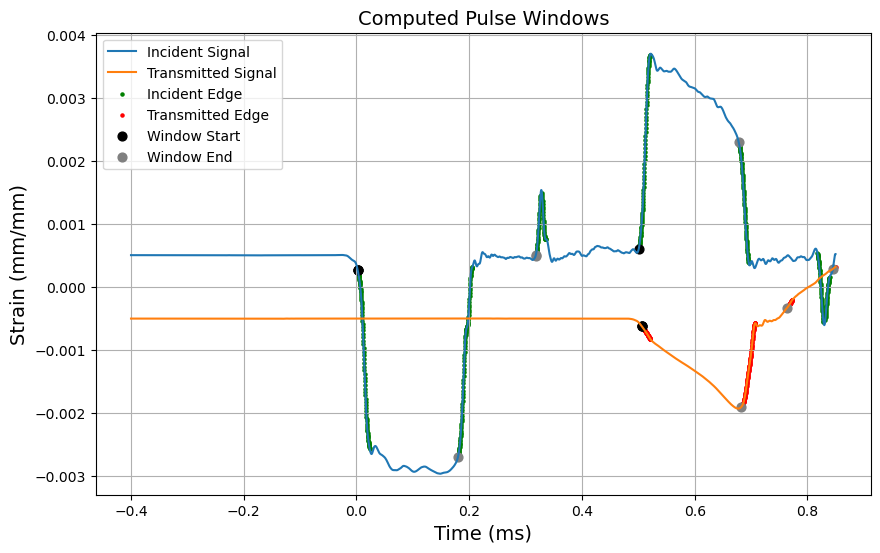

In [248]:
plt.figure(figsize=(10,6))
plt.plot(raw_data["Time"][:wavelet_points:20], raw_data["Incident Raw"][:wavelet_points:20]+5e-4, label = "Incident Signal")
plt.plot(raw_data["Time"][:wavelet_points:20], raw_data["Transmitted Raw"][:wavelet_points:20]-5e-4, label = "Transmitted Signal")

plt.scatter(raw_data["Time"][incident_edges[::20]], raw_data["Incident Raw"][incident_edges[::20]]+5e-4,
         marker = "o", s = 5, c="g", label = "Incident Edge")
plt.scatter(raw_data["Time"][transmitted_edges[::20]], raw_data["Transmitted Raw"][transmitted_edges[::20]]-5e-4,
         marker = "o", s = 5 , c = "r", label = "Transmitted Edge")

plt.scatter(raw_data["Time"][incident_start_approx], raw_data["Incident Raw"][incident_start_approx]+5e-4,
         marker = "o", s = 40, c="black", label = "Window Start")
plt.scatter(raw_data["Time"][incident_end_approx], raw_data["Incident Raw"][incident_end_approx]+5e-4,
         marker = "o", s = 40, c="gray", label = "Window End")

plt.scatter(raw_data["Time"][transmitted_start_approx], raw_data["Transmitted Raw"][transmitted_start_approx]-5e-4,
         marker = "o", s = 40, c="black")
plt.scatter(raw_data["Time"][transmitted_end_approx], raw_data["Transmitted Raw"][transmitted_end_approx]-5e-4,
         marker = "o", s = 40, c="gray")

plt.xlabel("Time (ms)", fontsize = 14)
plt.ylabel("Strain (mm/mm)", fontsize =14)
plt.title("Computed Pulse Windows", fontsize=14)
plt.legend(fontsize=10)
plt.grid()

### Extract Strain Signals

In [249]:
print(len(incident_start_approx))
incident_pair = 0
reflected_pair = -1 # Normally this changes based on experiment
transmitted_pair = 0

tail = pulse_data_points * 0.3

4


In [250]:
# Extract pulses from approximations
incident_extracted, incident_start = extract_pulse_window(raw_data["Incident Raw"], incident_start_approx[incident_pair],
                                                         incident_end_approx[incident_pair], pulse_data_points, 0.8, tail)
transmitted_extracted, transmitted_start = extract_pulse_window(raw_data["Transmitted Raw"], transmitted_start_approx[transmitted_pair],
                                                         transmitted_end_approx[transmitted_pair], pulse_data_points, 0.8, tail)

reflected_extracted, _ = extract_pulse_window(raw_data["Incident Raw"], incident_start_approx[reflected_pair],
                                                             incident_end_approx[reflected_pair], pulse_data_points, 0.8, tail, negative=False)

subset_points = min(len(incident_extracted), len(reflected_extracted), len(transmitted_extracted))

reflected_extracted = reflected_extracted[:subset_points]
incident_extracted = incident_extracted[:subset_points]
transmitted_extracted = transmitted_extracted[:subset_points]
time = np.linspace(0, pulse_duration, subset_points)


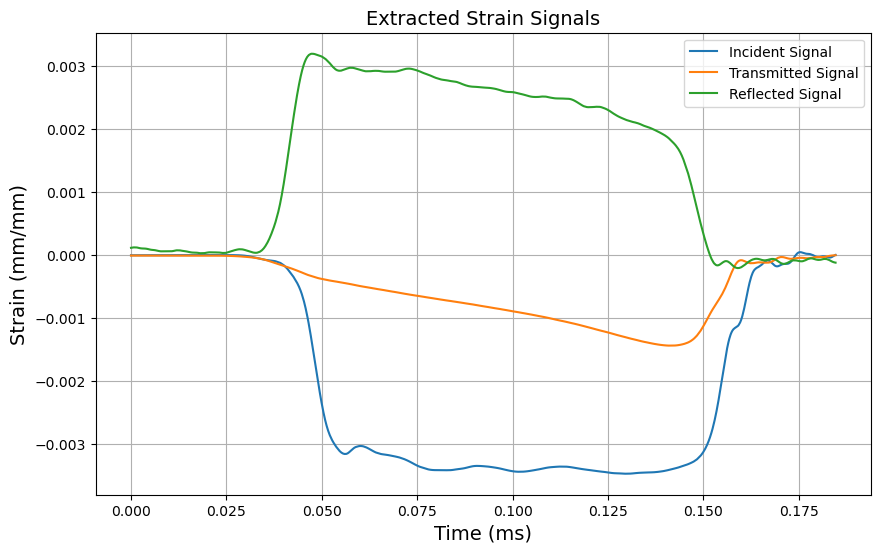

In [251]:
plt.figure(figsize=(10,6))
plt.plot(time, incident_extracted, label = "Incident Signal")
plt.plot(time, transmitted_extracted, label = "Transmitted Signal")
plt.plot(time, reflected_extracted, label = "Reflected Signal")

plt.xlabel("Time (ms)", fontsize = 14)
plt.ylabel("Strain (mm/mm)", fontsize =14)
plt.title("Extracted Strain Signals", fontsize=14)
plt.legend(fontsize=10)
plt.grid()

### Genetic Algorithm Section

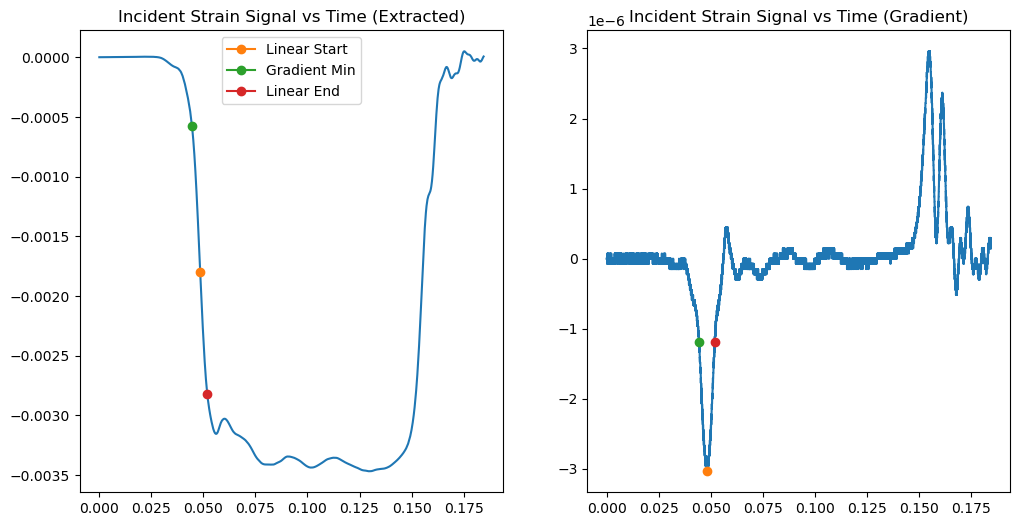

In [252]:
#####################################################################
# 1.  FIND THE LINEAR SECTION OF THE INCIDENT PULSE
#####################################################################

grad_inc = np.gradient(incident_extracted)

targetval = np.min(grad_inc) * 0.40         # 30 % of the steepest slope
minidx    = np.argmin(grad_inc)               # global minima, should represent steppest point 

fall_start = np.where(grad_inc[:minidx] >= targetval)[0][-1]
fall_end   = np.where(grad_inc[minidx:] >= targetval)[0][0] + minidx

linear_idx = np.arange(fall_start, fall_end)  # indices we will correlate using the Genetic Algorithm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(time, incident_extracted)
ax1.plot(time[minidx], incident_extracted[minidx], marker="o", label="Linear Start")
ax1.plot(time[fall_start], incident_extracted[fall_start], marker="o", label="Gradient Min")
ax1.plot(time[fall_end], incident_extracted[fall_end], marker="o", label = "Linear End")
ax1.set_title("Incident Strain Signal vs Time (Extracted)")
ax1.legend()

ax2.plot(time, grad_inc)
ax2.plot(time[minidx], grad_inc[minidx], marker="o")
ax2.plot(time[fall_start], grad_inc[fall_start], marker="o")
ax2.plot(time[fall_end], grad_inc[fall_end], marker="o")
ax2.set_title("Incident Strain Signal vs Time (Gradient)")
plt.show()

In [288]:
#####################################################################
# 2.  GA HYPERPARAMETERS
#####################################################################
POP_SIZE       = 500
N_GENERATIONS  = 15
MUT_RATE       = 0.12
XOVER_RATE     = 0.8
SHIFT_BOUND    = 3500                       # ± indices to explore

#####################################################################
# 3.  INITIAL POPULATION  (random integer shifts)
#####################################################################

population = [
    (np.random.randint(0, SHIFT_BOUND + 1),
     np.random.randint(0, SHIFT_BOUND + 1))
    for _ in range(POP_SIZE)
]

best_individual = None
best_fitness    = -np.inf
weights = dict(corr=0.5, corr2=0.0, u=0.15, sr=0.15, e=0.1)

#####################################################################
# 4.  MAIN GA LOOP
#####################################################################

for gen in range(N_GENERATIONS):

    # --- fitness evaluation ---
    fitness = [
        compute_fitness_physical(sh_t, sh_r,
                        incident_extracted,
                        transmitted_extracted,
                        reflected_extracted,
                        linear_idx, time, 
                        bar_wave_speed, specimen_length, 
                        weights)
        for sh_t, sh_r in population
    ]

    # --- keep global best ---
    gen_best_idx = int(np.argmax(fitness))
    if fitness[gen_best_idx] > best_fitness:
        best_fitness = fitness[gen_best_idx]
        best_individual = population[gen_best_idx]

    print(f"Gen {gen:02d}  |  best r = {best_fitness:.5f}  "
          f"shifts = {best_individual}")

    # --- build next generation ---
    new_pop = []
    while len(new_pop) < POP_SIZE:
        p1 = tournament_select(population, fitness, k=15)
        p2 = tournament_select(population, fitness, k=15)

        # single‑point crossover on the *pair* of shifts
        if np.random.rand() < XOVER_RATE:
            child = (p1[0], p2[1]) if np.random.rand() < 0.5 else (p2[0], p1[1])
        else:
            child = p1

        # mutation (± 5 samples) on each gene
        sh_t, sh_r = child
        if np.random.rand() < MUT_RATE:
            sh_t += np.random.randint(-5, 6)
        if np.random.rand() < MUT_RATE:
            sh_r += np.random.randint(-5, 6)

        # clip to bounds and append
        new_pop.append((
            int(np.clip(sh_t, -SHIFT_BOUND, SHIFT_BOUND)),
            int(np.clip(sh_r, -SHIFT_BOUND, SHIFT_BOUND))
        ))

    population = new_pop

print("\nFinished.")
print(f"Best individual: {best_individual}  |  r = {best_fitness:.5f}")

Gen 00  |  best r = 0.72935  shifts = (3086, 903)
Gen 01  |  best r = 0.73002  shifts = (3300, 903)
Gen 02  |  best r = 0.73074  shifts = (3431, 906)
Gen 03  |  best r = 0.73078  shifts = (3435, 907)
Gen 04  |  best r = 0.73079  shifts = (3440, 908)
Gen 05  |  best r = 0.73079  shifts = (3440, 907)
Gen 06  |  best r = 0.73080  shifts = (3445, 907)
Gen 07  |  best r = 0.73081  shifts = (3449, 907)
Gen 08  |  best r = 0.73082  shifts = (3451, 907)
Gen 09  |  best r = 0.73082  shifts = (3454, 907)
Gen 10  |  best r = 0.73083  shifts = (3458, 907)
Gen 11  |  best r = 0.73084  shifts = (3460, 907)
Gen 12  |  best r = 0.73085  shifts = (3464, 907)
Gen 13  |  best r = 0.73085  shifts = (3466, 907)
Gen 14  |  best r = 0.73086  shifts = (3470, 907)

Finished.
Best individual: (3470, 907)  |  r = 0.73086


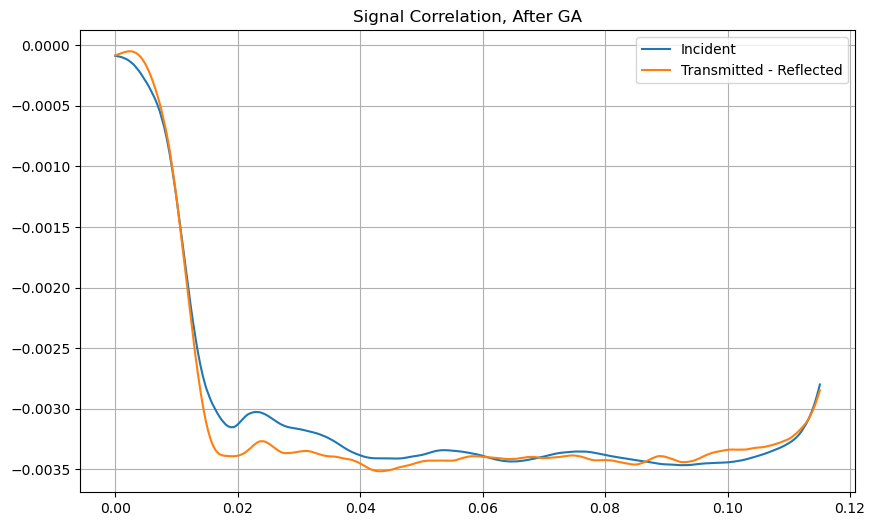

In [292]:
# ------------------------------------------------------------------
# POST‑GA TRIM  (optional, purely for visualisation or saving data)
# ------------------------------------------------------------------
pulse_start = 4900                                     # or user input
pulse_end   = int(pulse_start + (pulse_data_points * 1.03)) #Change this

# Apply shifts *first* so the trimmed slices include the new alignment
best_shift_t, best_shift_r = best_individual

# Manual 
#best_shift_r = -720
best_shift_t = 1800

incident_corrected = incident_extracted[pulse_start:pulse_end]
transmitted_corrected = shift_signal(transmitted_extracted, best_shift_t)[pulse_start:pulse_end]
reflected_corrected = shift_signal(reflected_extracted,   best_shift_r)[pulse_start:pulse_end]
cand_plot = transmitted_corrected - reflected_corrected
t = time[:int(pulse_end - pulse_start)]
#t = time[pulse_start:pulse_end]

plt.figure(figsize=(10,6))
plt.plot(t, incident_corrected,  label="Incident")
plt.plot(t, cand_plot, label="Transmitted - Reflected")
plt.title("Signal Correlation, After GA")
plt.legend(fontsize=10)
plt.grid()
plt.show()


### Secondary Data Calculations

In [293]:
sims = pd.DataFrame()
sims["Time (ms)"] = time
sims["Velocity (mm/ms)"] = bar_wave_speed * incident_extracted 
sims.to_csv(os.path.join(fig_path, f"{experiment_name}_initial_vel.csv"), index=False)


In [294]:
### Bar Displacement
u2W = bar_wave_speed * (incident_corrected + reflected_corrected)
u1W = bar_wave_speed * (transmitted_corrected)

### Bar Forces
F2W = bar_cross_section * (bar_elastic_modulus/1000) * (incident_corrected + reflected_corrected)
F1W = bar_cross_section * (bar_elastic_modulus/1000) * (transmitted_corrected)

## Eng Strain Rate
strain_rate_3W = (bar_wave_speed / specimen_length) * (incident_corrected - reflected_corrected - transmitted_corrected)
strain_rate_1W = (2*bar_wave_speed*reflected_corrected) / specimen_length

## Eng Strain
strain_3W = (bar_wave_speed / specimen_length) * cumulative_trapezoid(
                (incident_corrected - reflected_corrected - transmitted_corrected),
                t, initial=0)

strain_1W = ((2*bar_wave_speed) / specimen_length) * cumulative_trapezoid(
                reflected_corrected,
                t, initial=0)

## Eng Stress 
sigma_2W = (bar_elastic_modulus/1000) * (bar_cross_section / specimen_cross) * (incident_corrected + reflected_corrected)
sigma_1W = (bar_elastic_modulus/1000) * (bar_cross_section / specimen_cross) * (transmitted_corrected)

# True Stress True Strain Series
true_strain_3W = np.log(1 + strain_3W)
true_strain_1W = np.log(1 + strain_1W)
true_stress_2W = sigma_2W * (1 + strain_3W)
true_stress_1W = sigma_1W * (1 + strain_3W)

## Strain Energies
incident_SE = 0.5 * bar_cross_section * bar_wave_speed * bar_elastic_modulus * pulse_duration * (incident_corrected**2)
transmitted_SE = 0.5 * bar_cross_section * bar_wave_speed * bar_elastic_modulus * pulse_duration * (transmitted_corrected**2)
reflected_SE = 0.5 * bar_cross_section * bar_wave_speed * bar_elastic_modulus * pulse_duration * (reflected_corrected**2)

## Absorbed Energy 
delta_e = 0.5 * bar_cross_section * bar_wave_speed * bar_elastic_modulus * pulse_duration*(incident_corrected**2 - reflected_corrected**2 - transmitted_corrected**2)
delta_k = 0.5 * 1000 * bar_cross_section * (bar_wave_speed**3) * bar_density * pulse_duration * (incident_corrected**2 - reflected_corrected**2 - transmitted_corrected**2)
total_e = delta_e + delta_k


print(f"Max Strain Rate: {np.max(-strain_rate_3W)*1000 :.3f} 1/s")
print(f"Max Strain: {np.max(-strain_3W):.3f} mm/mm")
print(f"Max True Strain: {np.max(-true_strain_3W):.3f} mm/mm")


Max Strain Rate: 4772.579 1/s
Max Strain: 0.422 mm/mm
Max True Strain: 0.548 mm/mm


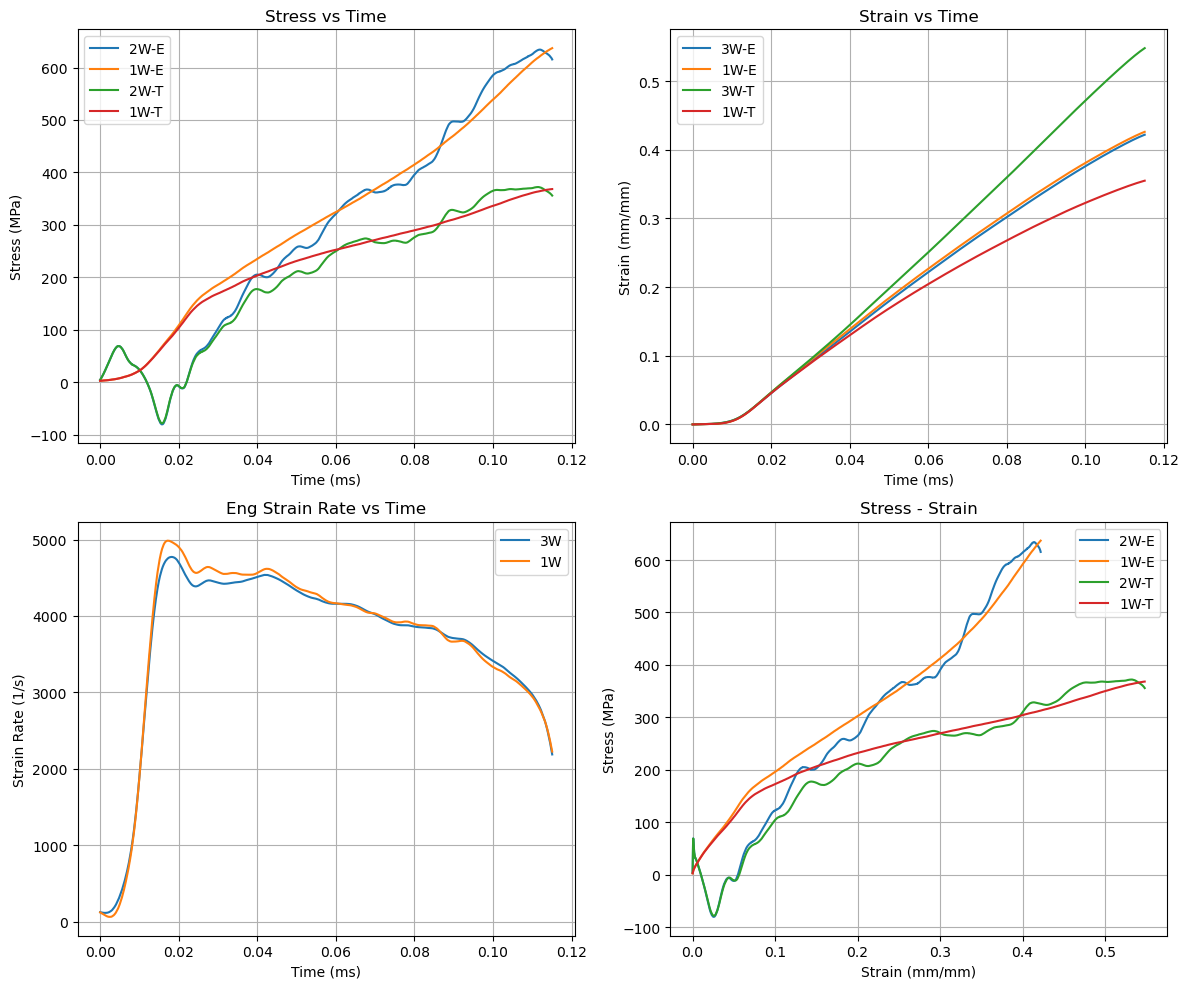

In [295]:
# Multi view plot, for precheck

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))

ax1.plot(t, -sigma_2W*1e3, label = "2W-E")
ax1.plot(t, -sigma_1W*1e3, label = "1W-E")
ax1.plot(t, -true_stress_2W*1e3, label = "2W-T")
ax1.plot(t, -true_stress_1W*1e3, label = "1W-T")
ax1.set_title("Stress vs Time")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Stress (MPa)")
ax1.legend()
ax1.grid()

ax2.plot(t, -strain_3W, label = "3W-E")
ax2.plot(t, strain_1W, label = "1W-E")
ax2.plot(t, -true_strain_3W, label = "3W-T")
ax2.plot(t, true_strain_1W, label = "1W-T")
ax2.set_title("Strain vs Time")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Strain (mm/mm)")
ax2.legend()
ax2.grid()

ax3.plot(t, -strain_rate_3W*1000, label = "3W")
ax3.plot(t, strain_rate_1W*1000, label = "1W")
ax3.set_title("Eng Strain Rate vs Time")
ax3.set_xlabel("Time (ms)")
ax3.set_ylabel("Strain Rate (1/s)")
ax3.legend()
ax3.grid()

ax4.plot(-strain_3W, -sigma_2W*1e3,  label = "2W-E")
ax4.plot(-strain_3W, -sigma_1W*1e3, label = "1W-E")
ax4.plot(-true_strain_3W, -true_stress_2W*1e3, label = "2W-T")
ax4.plot(-true_strain_3W, -true_stress_1W*1e3, label = "1W-T")
ax4.set_title("Stress - Strain")
ax4.set_xlabel("Strain (mm/mm)")
ax4.set_ylabel("Stress (MPa)")
ax4.legend()
ax4.grid()
plt.tight_layout()
plt.show()

## Data Saving

In [272]:
# Plot found edges on signals
edges_fig = go.Figure()
        
edges_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Incident Raw"], mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2)))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Transmitted Raw"], mode='lines', name='Transmitted',
                                                        line=dict(color='red', width=2))) 
# Add wavelet coefficient signals
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][incident_edges[::10]], y=raw_data["Incident Raw"][incident_edges[::10]], mode='markers',
                               marker=dict(color='green', size=6, symbol='circle'), name="Incident Edge"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][transmitted_edges[::10]], y=raw_data["Transmitted Raw"][transmitted_edges[::10]], mode='markers',
                               marker=dict(color='orange', size=6, symbol='circle'), name="Transmitted Edge"))

# Add approximate window start
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][incident_start_approx], y=raw_data["Incident Raw"][incident_start_approx], mode='markers',
                               marker=dict(color='purple', size=16, symbol='circle'), name="Approx Incident Start"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][incident_end_approx], y=raw_data["Incident Raw"][incident_end_approx], mode='markers',
                               marker=dict(color='darkturquoise', size=16, symbol='circle'), name="Approx Incident End"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][transmitted_start_approx], y=raw_data["Transmitted Raw"][transmitted_start_approx], mode='markers',
                               marker=dict(color='plum', size=16, symbol='circle'), name="Approx Transmitted Start"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][transmitted_end_approx], y=raw_data["Transmitted Raw"][transmitted_end_approx], mode='markers',
                               marker=dict(color='salmon', size=16, symbol='circle'), name="Approx Transmitted End"))

# Customize layout
edges_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                        title=dict(text="Detected Edges on Raw Pulse Data", x=0.5, y=0.95, xanchor="center",
                                   font=dict(size=20, color="black", family="Arial")),
                        xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                   tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                   gridcolor="lightgrey", gridwidth=1),
                        yaxis=dict(title=dict(text="Voltage", font=dict(family="Arial", size=16, color="black")),
                                   tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                   gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                        legend=dict(title="Strain Pulses", x=1.0, y=1.0, font=dict(size=12, color="black", family="Arial"),
                                    bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

edges_fig.write_html(os.path.join(fig_path, f"{experiment_name}_edges.html"), include_plotlyjs='cdn')

In [290]:
extracted_fig = go.Figure()
        
extracted_fig.add_trace(go.Scatter(x=time, y=incident_extracted , mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2)))
extracted_fig.add_trace(go.Scatter(x=time, y=transmitted_extracted , mode='lines', name='Transmitted', 
                                                        line=dict(color='red', width=2)))
if test_type == "SpecimenTest":
    extracted_fig.add_trace(go.Scatter(x=time, y=reflected_extracted , mode='lines', name='Reflected', 
                                                            line=dict(color='green', width=2)))  
# Customize layout
extracted_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                            title=dict(text="Extracted Strain Signals vs Time", x=0.5, y=0.95, xanchor="center",
                                       font=dict(size=20, color="black", family="Arial")),
                            xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                       tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                       gridcolor="lightgrey", gridwidth=1),
                            yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                       tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                       gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                            legend=dict(title="Strain Pulses", x=1.0, y=1.0, font=dict(size=12, color="black", family="Arial"),
                                        bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

extracted_fig.write_html(os.path.join(fig_path, f"{experiment_name}_extracted_pulse.html"), include_plotlyjs='cdn')

In [274]:
pulse_correlation = go.Figure()
        
pulse_correlation.add_trace(go.Scatter(x=t, y=(incident_corrected) , mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2))) 
pulse_correlation.add_trace(go.Scatter(x=t, y=(transmitted_corrected - reflected_corrected) , mode='lines', name='Transmitted - Reflected', 
                                                        line=dict(color='red', width=2)))
# Customize layout
pulse_correlation.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                 title=dict(text="Pulse Correlation vs Time", x=0.5, y=0.95, xanchor="center",
                                            font=dict(size=20, color="black", family="Arial")),
                                 xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                            tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                            gridcolor="lightgrey", gridwidth=1),
                                 yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                            tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                            gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                 legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                             font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                             bordercolor="black", borderwidth=2))
        

pulse_correlation.write_html(os.path.join(fig_path, f"{experiment_name}_pulse_correlation.html"), include_plotlyjs='cdn')

In [296]:
alligned_pulse_fig = go.Figure()
        
alligned_pulse_fig.add_trace(go.Scatter(x=t, y=incident_corrected , mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2))) 
alligned_pulse_fig.add_trace(go.Scatter(x=t, y=transmitted_corrected , mode='lines', name='Transmitted', 
                                                        line=dict(color='red', width=2)))
if test_type == "SpecimenTest":
    alligned_pulse_fig.add_trace(go.Scatter(x=t, y=reflected_corrected , mode='lines', name='Reflected', 
                                                            line=dict(color='green', width=2))) 
# Customize layout
alligned_pulse_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                 title=dict(text="Extracted Strain Signals vs Time", x=0.5, y=0.95, xanchor="center",
                                            font=dict(size=20, color="black", family="Arial")),
                                 xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                            tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                            gridcolor="lightgrey", gridwidth=1),
                                 yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                            tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                            gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                 legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                             font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                             bordercolor="black", borderwidth=2))
        

alligned_pulse_fig.write_html(os.path.join(fig_path, f"{experiment_name}_aligned_pulse.html"), include_plotlyjs='cdn')

In [276]:
bar_displacement_fig = go.Figure()
        
bar_displacement_fig.add_trace(go.Scatter(x=t, y=-u2W , mode='lines', name='Front Surface', line=dict(color='blue', width=2))) 
#bar_displacement_fig.add_trace(go.Scatter(x=time, y=-u3 , mode='lines', name='Front Surface?', line=dict(color='blue', width=2)))
bar_displacement_fig.add_trace(go.Scatter(x=t, y=-u1W , mode='lines', name='Back Surface', line=dict(color='red', width=2)))

# Customize layout
bar_displacement_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                   title=dict(text="Bar Displacement vs Time", x=0.5, y=0.95, xanchor="center",
                                              font=dict(size=20, color="black", family="Arial")),
                                   xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                              tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                              gridcolor="lightgrey", gridwidth=1),
                                   yaxis=dict(title=dict(text="Velocity (mm/ms)", font=dict(family="Arial", size=16, color="black")),
                                              tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                              gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                   legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                               font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                               bordercolor="black", borderwidth=2))
        

bar_displacement_fig.write_html(os.path.join(fig_path, f"{experiment_name}_bar_disp.html"), include_plotlyjs='cdn')

In [277]:
bar_forces_fig = go.Figure()
        
bar_forces_fig.add_trace(go.Scatter(x=t, y=-F2W , mode='lines', name='Front Surface', line=dict(color='blue', width=2))) 
bar_forces_fig.add_trace(go.Scatter(x=t, y=-F1W , mode='lines', name='Back Surface', line=dict(color='red', width=2)))

# Customize layout
bar_forces_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Pulse Force vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Force (kN)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0, 
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))


bar_forces_fig.write_html(os.path.join(fig_path, f"{experiment_name}_force.html"), include_plotlyjs='cdn')

In [278]:
eng_strain_rate_fig = go.Figure()
        
eng_strain_rate_fig.add_trace(go.Scatter(x=t, y=-strain_rate_3W*1e3 , mode='lines', name='3-Wave Method', line=dict(color='blue', width=2))) 
eng_strain_rate_fig.add_trace(go.Scatter(x=t, y=strain_rate_1W*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_strain_rate_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                  title=dict(text="Engineering Strain Rate vs Time", x=0.5, y=0.95, xanchor="center",
                                             font=dict(size=20, color="black", family="Arial")),
                                  xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                             tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                             gridcolor="lightgrey", gridwidth=1),
                                  yaxis=dict(title=dict(text="Engineering Strain Rate (1/s)", font=dict(family="Arial", size=16, color="black")),
                                             tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                             gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                  legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                              font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                              bordercolor="black", borderwidth=2))        

eng_strain_rate_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_strain_rate.html"), include_plotlyjs='cdn')

In [279]:
eng_strain_fig = go.Figure()
        
eng_strain_fig.add_trace(go.Scatter(x=t, y=-strain_3W , mode='lines', name='3-Wave Method', line=dict(color='blue', width=2))) 
eng_strain_fig.add_trace(go.Scatter(x=t, y=strain_1W, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_strain_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Engineering Strain vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Engineering Strain (mm/mm)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))

        

eng_strain_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_strain.html"), include_plotlyjs='cdn')


In [280]:
eng_stress_fig = go.Figure()
        
eng_stress_fig.add_trace(go.Scatter(x=t, y=-sigma_2W*1e3 , mode='lines', name='2-Wave Method', line=dict(color='blue', width=2))) 
eng_stress_fig.add_trace(go.Scatter(x=t, y=-sigma_1W*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_stress_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Engineering Stress vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Engineering Stress (MPa)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))
        

eng_stress_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_stress.html"), include_plotlyjs='cdn')

In [281]:
# Stress - Strain 
eng_stress_strain_fig = go.Figure()
        
eng_stress_strain_fig.add_trace(go.Scatter(x=-strain_3W, y=-sigma_2W*1e3 , mode='lines', name='2-Wave Method', line=dict(color='blue', width=2)))
eng_stress_strain_fig.add_trace(go.Scatter(x=-strain_3W, y=-sigma_1W*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_stress_strain_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                    title=dict(text="Engineering Stress vs Strain", x=0.5, y=0.95, xanchor="center",
                                               font=dict(size=20, color="black", family="Arial")),
                                    xaxis=dict(title=dict(text="Strain (mm/mm)", font=dict(family="Arial", size=16, color="black")),
                                               tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                               gridcolor="lightgrey", gridwidth=1),
                                    yaxis=dict(title=dict(text="Engineering Stress (MPa)", font=dict(family="Arial", size=16, color="black")),
                                               tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                               gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                    legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                                font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                                bordercolor="black", borderwidth=2))

        

eng_stress_strain_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_stress_strain.html"), include_plotlyjs='cdn')


In [282]:
true_stress_strain_fig = go.Figure()
        
true_stress_strain_fig.add_trace(go.Scatter(x=-true_strain_3W , y=-true_stress_2W*1e3 , mode='lines', name='2-Wave Method', line=dict(color='blue', width=2)))
true_stress_strain_fig.add_trace(go.Scatter(x=-true_strain_3W , y=-true_stress_1W*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))
# Customize layout
true_stress_strain_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                     title=dict(text="True Stress vs Strain", x=0.5, y=0.95, xanchor="center",
                                                font=dict(size=20, color="black", family="Arial")),
                                     xaxis=dict(title=dict(text="True Strain (mm/mm)", font=dict(family="Arial", size=16, color="black")),
                                                tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                                gridcolor="lightgrey", gridwidth=1),
                                     yaxis=dict(title=dict(text="True Stress (MPa)", font=dict(family="Arial", size=16, color="black")),
                                                tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                                gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                     legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                                 font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                                 bordercolor="black", borderwidth=2))
        

true_stress_strain_fig.write_html(os.path.join(fig_path, f"{experiment_name}_true_stress_strain.html"), include_plotlyjs='cdn')

In [283]:
strain_energy_fig = go.Figure()
        
strain_energy_fig.add_trace(go.Scatter(x=t, y=incident_SE*1e-3, mode='lines', name='Incident', line=dict(color='blue', width=2))) 
strain_energy_fig.add_trace(go.Scatter(x=t, y=transmitted_SE*1e-3, mode='lines', name='Transmitted', line=dict(color='red', width=2))) 
strain_energy_fig.add_trace(go.Scatter(x=t, y=reflected_SE*1e-3, mode='lines', name='Reflected', line=dict(color='orange', width=2))) 


# Customize layout
strain_energy_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Strain Energy vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Strain Energy (kJ)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))

        
strain_energy_fig.write_html(os.path.join(fig_path, f"{experiment_name}_strain_energies.html"), include_plotlyjs='cdn')


In [284]:
abs_energy_fig = go.Figure()
        
abs_energy_fig.add_trace(go.Scatter(x=t, y=delta_e*1e-3, mode='lines', name='Incident', line=dict(color='blue', width=2))) 
abs_energy_fig.add_trace(go.Scatter(x=t, y=delta_k*1e-3, mode='lines', name='Transmitted', line=dict(color='red', width=2))) 
abs_energy_fig.add_trace(go.Scatter(x=t, y=total_e*1e-3, mode='lines', name='Reflected', line=dict(color='orange', width=2))) 


# Customize layout
abs_energy_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Absorbed Energy vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Strain Energy (kJ)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))

        
abs_energy_fig.write_html(os.path.join(fig_path, f"{experiment_name}_absorbed_energies.html"), include_plotlyjs='cdn')


In [285]:
results_df = pd.DataFrame()

results_df["Time"] = t.astype(np.float32)
results_df["Incident"] = incident_corrected
results_df["Reflected"] = reflected_corrected
results_df["Transmitted"] = transmitted_corrected

results_df["Front Displacement"] = u2W
results_df["Back Displacement"] = u1W
results_df["Front Force"]= F2W 
results_df["Back Force"]= F1W
results_df["Strain Rate 3W"]= strain_rate_3W
results_df["Strain Rate 1W"]= strain_rate_1W
results_df["Engineering Strain 3W"] = strain_3W.astype(np.float32)
results_df["Engineering Strain 1W"] = strain_1W.astype(np.float32)
results_df["Engineering Stress 2W"] = sigma_2W
results_df["Engineering Stress 1W"] = sigma_1W
results_df["True Strain 3W"] = true_strain_3W.astype(np.float32)
results_df["True Strain 1W"] = true_strain_1W.astype(np.float32)
results_df["True Stress 2W"] = true_stress_2W.astype(np.float32)
results_df["True Stress 1W"] = true_stress_1W.astype(np.float32)
results_df["Inident SE"] = incident_SE.astype(np.float32)
results_df["Transmitted SE"] = transmitted_SE.astype(np.float32)
results_df["Reflected SE"] = reflected_SE.astype(np.float32)
results_df["Delta E"] = delta_e.astype(np.float32)
results_df["Delta K"] = delta_k.astype(np.float32)
results_df["Total E"] = total_e.astype(np.float32)
results_df["True Strain Rate 1W"] = np.log(1 + results_df["Strain Rate 1W"]).astype(np.float32)
results_df["True Strain Rate 3W"] = np.log(1 - results_df["Strain Rate 3W"]).astype(np.float32) 


results_df.to_csv(os.path.join(fig_path, f"{experiment_name}_secondary_data.csv"), index = False)






## Correction of previous analysis

In [286]:
edit_folder = os.path.join(script_dir, "results", "SS316_3D")
secondary_files = glob.glob(os.path.join(edit_folder, "**\\*secondary_data.csv"), recursive=True)

for file in secondary_files:
    sec_data = pd.read_csv(file)
    time_0 = sec_data["Time"][0]
    sec_data["Time"] = sec_data["Time"] - time_0  #Offsets time by t=n
    time_new = sec_data["Time"][0]

    print(f"File - {os.path.basename(file)} ,Previous Time: {time_0}, New Time: {time_new}")

    # Add True Strain Rate 
    sec_data["True Strain Rate 1W"] = np.log(1 + sec_data["Strain Rate 1W"])
    sec_data["True Strain Rate 3W"] = np.log(1 - sec_data["Strain Rate 3W"])      

    sec_data.to_csv(file)
    

File - SS316_009_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_010_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_011_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_012_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_014_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_013_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_015_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_016_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_017_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_018_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_019_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_020_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_021_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File - SS316_022_secondary_data.csv ,Previous Time: 0.0, New Time: 0.0
File -